In [12]:
import sys
sys.path.insert(0, "../..")

In [13]:
import numpy as np
from matplotlib import pyplot as plt

from module.base.network import Network

from module.components.discrete_gaussian1D import DiscreteGaussian1D
from module.components.discrete_gaussian2D import DiscreteGaussian2D
from module.components.lawrence_dist import LawrenceDist

from module.simulation.meanfield import MeanField
from module.simulation.set_meanfield2 import SetMeanField2

import module.components.CONST as CONST

In [14]:
net = Network(3,3,1, [[0,0,0], [2,0,0], [0,2,0], [2,2,0]])
net.set_voltage_config([-3.302944822433594996e-01, -1.300645682722810503e-01, 2.974199217486594438e-01, -1.754745629759278669e-01], 1.307111545318153378e-01)

mf = MeanField(net)

g2 = DiscreteGaussian2D()
g1 = DiscreteGaussian1D()

In [15]:
means = np.zeros(net.N_particles)
vars = np.ones(net.N_particles) * 0.1

In [33]:
neighbour_table = net.get_nearest_neighbours(np.arange(0, net.N_particles))

covs = np.zeros((net.N_particles, 6))
def get_cov(i, j):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 0:
        return 0

    return covs[i, table_index[0]]

def set_cov(i, j, value):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 1:
        covs[i, table_index[0]] = value

    table_index = np.where(neighbour_table[j] == i)[0]
    if table_index.shape[0] == 1:
        covs[j, table_index[0]] = value

dcovs = np.zeros((net.N_particles, 6))
def get_dcov(i, j):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 0:
        return 0

    return dcovs[i, table_index[0]]

def set_dcov(i, j, value):
    table_index = np.where(neighbour_table[i] == j)[0]
    if table_index.shape[0] == 1:
        dcovs[i, table_index[0]] = value

    table_index = np.where(neighbour_table[j] == i)[0]
    if table_index.shape[0] == 1:
        dcovs[j, table_index[0]] = value

---

In [17]:
def calc_effective_states(i, j):
    phase_space = g2.phase_space
    states = np.repeat(np.expand_dims(means, axis = [0, 1]), phase_space.shape[0], axis = 0)
    states = np.repeat(states, phase_space.shape[1], axis = 1)

    states[:,:,i] = phase_space[:,:,0]
    states[:,:,j] = phase_space[:,:,1]
    
    return states

---
$$
\langle I_{ij} \rangle
$$

In [18]:
def calc_R_island(i, j):
    states = calc_effective_states(i, j)
    rates = net.calc_rate_island(states, i, j)
    return rates

def calc_R_island_inv(i, j):
    states = calc_effective_states(i, j)
    rates = net.calc_rate_island(states, j, i)
    return rates

---
$$
\langle I_{ei} \rangle
$$

In [19]:
def calc_R_from_electrode(electrode_index):
    phase_space = g1.phase_space
    states = np.expand_dims(means, axis = 0)
    states = np.repeat(states, phase_space.shape[0], axis = 0)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    states[:, island_index] = phase_space
    rates = net.calc_rate_from_electrode(states, electrode_index)
    return rates

def calc_R_to_electrode(electrode_index):
    phase_space = g1.phase_space
    states = np.expand_dims(means, axis = 0)
    states = np.repeat(states, phase_space.shape[0], axis = 0)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    states[:, island_index] = phase_space
    rates = net.calc_rate_to_electrode(states, electrode_index)
    return rates

---
$$
\langle n_i I_{ei} \rangle
$$

In [20]:
def calc_nR_to_electrode(electrode_index):
    phase_space = g1.phase_space
    rates = calc_R_to_electrode(electrode_index)
    values = rates * phase_space 
    return values

def calc_nR_from_electrode(electrode_index):
    phase_space = g1.phase_space
    rates = calc_R_from_electrode(electrode_index)
    values = rates * phase_space 
    return values

---
$$
\langle n_i I_{ej} \rangle
$$

In [23]:
def calc_nR_from_electrode_2(i, electrode_index):
    phase_space = g2.phase_space
    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])

    states = calc_effective_states(i, island_index)
    rates = net.calc_rate_from_electrode(states, electrode_index)

    return rates * phase_space[:,:,0]

def calc_nR_to_electrode_2(i, electrode_index):
    phase_space = g2.phase_space
    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])

    states = calc_effective_states(i, island_index)
    rates = net.calc_rate_to_electrode(states, electrode_index)

    return rates * phase_space[:,:,0]

---
$$
\langle n_j I_{ij} \rangle
$$

In [24]:
def calc_nR_island(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island(i, j)
    values = rates * phase_space[:,:,1] 
    return values

def calc_nR_island_inv(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island_inv(i, j)
    values = rates * phase_space[:,:,1] 
    return values

---
$$
\langle n_i I_{ij} \rangle
$$

In [54]:
def calc_nR_island_alt(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island(i, j)
    values = rates * phase_space[:,:,0] 
    return values

def calc_nR_island_inv_alt(i, j):
    phase_space = g2.phase_space
    rates = calc_R_island_inv(i, j)
    values = rates * phase_space[:,:,0] 
    return values

---

In [26]:
l_R = np.zeros(net.N_particles)
r_R = np.zeros(net.N_particles)

l_nR = np.zeros(net.N_particles)
r_nR = np.zeros(net.N_particles)

for i in range(net.N_particles):
    for j in neighbour_table[i]:
        if not j == -1: # all neighbour relations
            probs = g2.calc_prob(means[j], means[i], vars[j], vars[i],get_cov(i, j))
            l_R[i] += np.sum(probs * calc_R_island(j, i))
            l_nR[i] += np.sum(probs * calc_nR_island(j, i))
            r_R[i] += np.sum(probs * calc_R_island_inv(j, i))
            r_nR[i] += np.sum(probs * calc_nR_island_inv(j, i))
            

In [27]:
l_R_electrodes = np.zeros(net.N_particles)
r_R_electrodes = np.zeros(net.N_particles)

l_nR_electrodes = np.zeros(net.N_particles)
r_nR_electrodes = np.zeros(net.N_particles)

for electrode_index, pos in enumerate(net.electrode_pos):
    i = net.get_linear_indices(pos)

    probs = g1.calc_prob(means[i], vars[i])
    l_R_electrodes[i] += np.sum(probs * calc_R_from_electrode(electrode_index)) 
    l_nR_electrodes[i] += np.sum(probs * calc_nR_from_electrode(electrode_index))

    r_R_electrodes[i] += np.sum(probs * calc_R_to_electrode(electrode_index)) 
    r_nR_electrodes[i] += np.sum(probs * calc_nR_to_electrode(electrode_index))


In [28]:
# islands
I_islands = l_R - r_R
I_dag_islands = l_R + r_R

nI_islands = l_nR - r_nR

# electrodes
I_electrodes = l_R_electrodes - r_R_electrodes
I_dag_electrodes = l_R_electrodes + r_R_electrodes

nI_electrodes = l_nR_electrodes - r_nR_electrodes

In [29]:
I = I_islands + I_electrodes
I_dag = I_dag_islands + I_dag_electrodes
nI = nI_islands + nI_electrodes

In [30]:
d_mean = I
d_var = (2 * nI + I_dag) - 2 * means * I

In [63]:
dcovs = np.zeros((net.N_particles, 6)) # reset dcovs
  
for i in range(net.N_particles):
    for j in neighbour_table[i]:
        if not j == -1:
            probs = g2.calc_prob(means[i], means[j], vars[i], vars[j], get_cov(i, j))
            probs2 = g2.calc_prob(means[j], means[i], vars[j], vars[i], get_cov(i, j))
            island_indices = net.get_linear_indices(net.electrode_pos)


            # < ni Ij >
            dcov = means[i] * I_islands[j]
            dcov -= means[i] * np.sum(probs * (calc_R_island(i, j) - calc_R_island_inv(i, j)))
            dcov += np.sum(probs * (calc_nR_island_alt(i, j) - calc_nR_island_inv_alt(i, j)))

            electrode_index = np.where(island_indices == j)[0]
            if electrode_index.shape[0] == 1:
                dcov += np.sum(probs * (calc_nR_from_electrode_2(i, electrode_index[0]) - calc_nR_to_electrode_2(i, electrode_index[0])))


            # < nj Ii >
            dcov += means[j] * I_islands[i]
            dcov -= means[j] * np.sum(probs2 * (calc_R_island(j, i) - calc_R_island_inv(j, i)))
            dcov += np.sum(probs2 * (calc_nR_island_alt(j, i) - calc_nR_island_inv_alt(j, i)))

            electrode_index = np.where(island_indices == i)[0]
            if electrode_index.shape[0] == 1:
                dcov += np.sum(probs2 * (calc_nR_from_electrode_2(j, electrode_index[0]) - calc_nR_to_electrode_2(j, electrode_index[0])))

            # < I^dag_ij >
            dcov += np.sum(probs * (calc_R_island(i, j) + calc_R_island_inv(i, j)))

            set_dcov(i,j, get_dcov(i,j) + dcov)

In [59]:
dcovs

array([[ 0.        , 22.061749  ,  0.        , 28.02035454,  0.        ,
         0.        ],
       [22.061749  ,  6.39322094,  0.        ,  1.41291052,  0.        ,
         0.        ],
       [ 6.39322094,  0.        ,  0.        ,  8.55663359,  0.        ,
         0.        ],
       [ 0.        ,  0.34001902, 28.02035454, 10.47558653,  0.        ,
         0.        ],
       [ 0.34001902,  1.02370391,  1.41291052,  0.29012846,  0.        ,
         0.        ],
       [ 1.02370391,  0.        ,  8.55663359, 10.92966187,  0.        ,
         0.        ],
       [ 0.        ,  8.31217179, 10.47558653,  0.        ,  0.        ,
         0.        ],
       [ 8.31217179, 16.90323756,  0.29012846,  0.        ,  0.        ,
         0.        ],
       [16.90323756,  0.        , 10.92966187,  0.        ,  0.        ,
         0.        ]])

---
## Run

In [62]:
means = np.zeros(net.N_particles)
vars = np.ones(net.N_particles)

In [65]:
dt = 0.05
for epoch in range(60):
    l_R = np.zeros(net.N_particles)
    r_R = np.zeros(net.N_particles)

    l_nR = np.zeros(net.N_particles)
    r_nR = np.zeros(net.N_particles)

    for i in range(net.N_particles):
        for j in neighbour_table[i]:
            if not j == -1: # all neighbour relations
                probs = g2.calc_prob(means[j], means[i], vars[j], vars[i],get_cov(i, j))
                l_R[i] += np.sum(probs * calc_R_island(j, i))
                l_nR[i] += np.sum(probs * calc_nR_island(j, i))
                r_R[i] += np.sum(probs * calc_R_island_inv(j, i))
                r_nR[i] += np.sum(probs * calc_nR_island_inv(j, i))
                
    l_R_electrodes = np.zeros(net.N_particles)
    r_R_electrodes = np.zeros(net.N_particles)

    l_nR_electrodes = np.zeros(net.N_particles)
    r_nR_electrodes = np.zeros(net.N_particles)

    for electrode_index, pos in enumerate(net.electrode_pos):
        i = net.get_linear_indices(pos)

        probs = g1.calc_prob(means[i], vars[i])
        l_R_electrodes[i] += np.sum(probs * calc_R_from_electrode(electrode_index)) 
        l_nR_electrodes[i] += np.sum(probs * calc_nR_from_electrode(electrode_index))

        r_R_electrodes[i] += np.sum(probs * calc_R_to_electrode(electrode_index)) 
        r_nR_electrodes[i] += np.sum(probs * calc_nR_to_electrode(electrode_index))

    # islands
    I_islands = l_R - r_R
    I_dag_islands = l_R + r_R

    nI_islands = l_nR - r_nR

    # electrodes
    I_electrodes = l_R_electrodes - r_R_electrodes
    I_dag_electrodes = l_R_electrodes + r_R_electrodes

    nI_electrodes = l_nR_electrodes - r_nR_electrodes
    I = I_islands + I_electrodes
    I_dag = I_dag_islands + I_dag_electrodes
    nI = nI_islands + nI_electrodes
    d_mean = I
    d_var = (2 * nI + I_dag) - 2 * means * I

    means += dt * d_mean
    vars += dt * d_var

    if  epoch % 10 == 0:
        print(np.mean(np.abs(d_mean)) , np.mean(np.abs(d_var)))

0.0020782269601723837 0.0004309602114983735
0.0005033203515268801 0.00010431289086383982
0.00012192054826432042 2.5264427965809672e-05
2.9534454187580333e-05 6.1199340766245055e-06
7.154606414625262e-06 1.4825179805119603e-06
1.733180111824279e-06 3.5913440333326347e-07


In [66]:
def calc_expected_electrode_rates(electrode_index):
    r = calc_R_from_electrode(electrode_index) - calc_R_to_electrode(electrode_index)

    island_index = net.get_linear_indices(net.electrode_pos[electrode_index])
    probs = g1.calc_prob(means[island_index], vars[island_index])
    ex = np.sum(probs * r)

    return ex

In [79]:
means * CONST.electron_charge

array([-1.36772956, -1.11889905, -1.0817349 , -0.79978096, -0.88909403,
       -0.98636057, -0.19404293, -0.67431201, -1.03265477])

In [73]:
vars

array([2.79876446, 1.01601662, 0.29683568, 2.61921417, 1.02380708,
       0.43227572, 3.94939212, 1.87838371, 1.44377967])

In [74]:
calc_expected_electrode_rates(3) * CONST.electron_charge

-2.4540908632965195

In [75]:
mf_means = mf.numeric_integration_solve(N = 300)
mf_means * CONST.electron_charge

array([-1.37115934, -1.12443741, -1.07374634, -0.77857507, -0.8991611 ,
       -0.98242856, -0.18907492, -0.66938415, -1.04267591])

In [76]:
mf.calc_expected_electrode_rates(mf_means, 3) * CONST.electron_charge

-2.4102219170392982

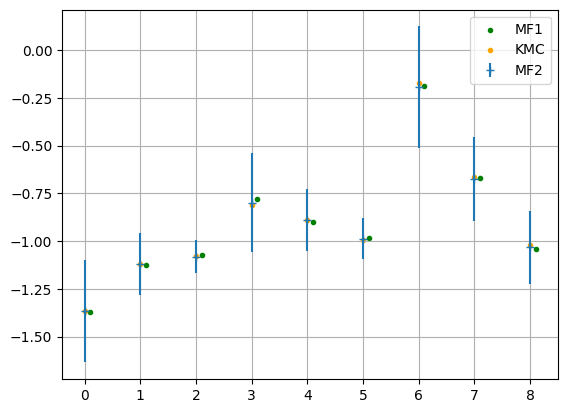

In [96]:
plt.errorbar(np.arange(net.N_particles), means * CONST.electron_charge, yerr = np.sqrt(vars) * CONST.electron_charge, linestyle = "", marker = "+", label = "MF2")
plt.scatter(np.arange(net.N_particles)+0.1, mf_means * CONST.electron_charge, label = "MF1", marker = ".", color = "g")

kmc = np.array( [-1.254212783505315842e+00, -5.529546430521703471e-01, -6.924668460202365594e-01, -2.440457304593303123e-01, -3.201983014383849024e-01, -4.263217158449596478e-01, 8.028724727885709900e-01, -9.563163544480711431e-02, -6.965640548617082484e-01])
plt.scatter(np.arange(net.N_particles), kmc - net.dq, label = "KMC", marker = ".", color ="orange")
plt.legend()
plt.grid()